# Birth Month Bias in the NHL
> Lets examine the effect that birth month has on players making it to the NHL, and the effect that it has on their career once they actually make it!

- comments: true

In [28]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from numpy import number
from bokeh.models import ColumnDataSource, HBar, Segment, Rect, Select, CustomJS, DataTable, TableColumn, RadioButtonGroup
from bokeh.layouts import layout, column, row
from bokeh.palettes import Colorblind
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from IPython.core.display import display, HTML

In [2]:
#hide

def returnGrouping(month):
    early = ['January', 'February', 'March']
    earlyMid = ['April', 'May', 'June']
    lateMid = ['July', 'August', 'September']
    late = ['October', 'November', 'December']
    if month in early:
        return 'Early'
    elif month in earlyMid:
        return 'Early Middle'
    elif month in lateMid:
        return 'Late Middle'
    elif month in late:
        return 'Late'
    return 'None'

players_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\person.csv")
players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], format="%Y-%m-%d %H:%M:%S-%f")
players_df['birth_month_number'] = players_df['birth_date'].dt.month
players_df['birth month'] = players_df['birth_date'].dt.month_name()
players_df['Year Grouping'] = players_df['birth month'].apply(returnGrouping)
players_df = players_df.sort_values(by='birth_month_number')

roster_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\roster.csv")
teams_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\teams.csv")
nhl_stats_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\playerStats.csv")
nhl_stats_df = nhl_stats_df[(nhl_stats_df['league_id'] == 133) & (nhl_stats_df['games'] > 9)]

reduced_stats_df = nhl_stats_df[[
    'person_id',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',
]]
career_stats_df = pd.DataFrame(reduced_stats_df.groupby(by='person_id', sort=False).sum())
birth_months_df = players_df[['person_id', 'Year Grouping', 'birth_month_number']]
career_stats_df = pd.merge(left=career_stats_df, right=birth_months_df, on='person_id')
career_stats_df = career_stats_df.sort_values(by='birth_month_number')
career_stats_df = career_stats_df[[
    'Year Grouping',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',]]
rename_map = {'power_play_goals': 'power play goals', 
              'power_play_assists': 'power play assists',
              'blocked_shots': 'blocked shots',
}
career_stats_df = career_stats_df.rename(columns=rename_map)
df = career_stats_df
career_stats_df['points'] = df['goals'] + df['assists']
career_stats_df['power play points'] = df['power play goals'] + df['power play assists'] 
career_stats_df['shooting percentage'] = df['goals'] / df['shots'] * 100

career_stats_by_game_df = pd.DataFrame()
career_stats_by_game_df['Year Grouping'] = career_stats_df['Year Grouping']
career_stats_by_game_df['assists'] = career_stats_df['assists'] / career_stats_df['games']
career_stats_by_game_df['goals'] = career_stats_df['goals'] / career_stats_df['games']
career_stats_by_game_df['points'] = career_stats_df['points'] / career_stats_df['games']
career_stats_by_game_df['pim'] = career_stats_df['pim'] / career_stats_df['games']
career_stats_by_game_df['shots'] = career_stats_df['shots'] / career_stats_df['games']
career_stats_by_game_df['hits'] = career_stats_df['hits'] / career_stats_df['games']
career_stats_by_game_df['power play goals'] = career_stats_df['power play goals'] / career_stats_df['games']
career_stats_by_game_df['power play assists'] = career_stats_df['power play assists'] / career_stats_df['games']
career_stats_by_game_df['power play points'] = career_stats_df['power play points'] / career_stats_df['games']
career_stats_by_game_df['blocked shots'] = career_stats_df['blocked shots'] / career_stats_df['games']
career_stats_by_game_df['shifts'] = career_stats_df['shifts'] / career_stats_df['games']

# grouping by Year Grouping for year grouping seaborn histogram
yearly_grouping_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False))
yearly_grouping_percents_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False, normalize=True))
yearly_grouping_df['Percent'] = yearly_grouping_percents_df['Year Grouping'] * 100
yearly_grouping_df['Percent'] = yearly_grouping_df['Percent'].round(1)

The ten thousand hour rules, popularized in Malcolm Gladwell's book Outliers, has become something of a mantra for a subculture of "rise and grinders" who strive to put in the time estimated to achieve mastery in their given vocations. While that is certainly a worthy goal, an element of the book is lost in the kind of "modern myth" which that rule has become. When Gladwell writes about it, he is really pointing out that for many people who do achieve mastery in a field, there is an element of luck that allows them to put in far more time than many others. One example that he gives is the effect the birth month of a hockey player has on their chances of become a professional. Players born in the earlier months of the year seem to make it to the National Hockey League (NHL) in larger numbers than players born in the later months of the year. This post will examine if that rule still holds in todays NHL, and will go further to explore how birth month affects the careers of the players who do make it the NHL.

The chapter of Outliers that dives into this is based on a 1985 paper published by a group of Canadian phsycologist (R.H. Barnsley, A.H. Thompson, and P.E. Barnsley) titled 'Hockey Success and Birthdate: The Relative Age Effect'. It gives their findings that almost twice as many players are making it to the NHL who are born in the months of January, February, and March compared to the months of October, November, and December. They found that if you divided the year into half, players from the first half of the year represented a total of 61.8% of the player pool compared to 38.2 for the second half. As well, they found similar numbers in the junior system when examining the Western Hockey League and the Ontario Hockey League. Its thought in the paper that this is the result of something called the Relative Age Effect, the ugly result of age grouping. In Canada, the cutoff date for minor hockey is December 31st of that year. This means a player born in January will be almost a full year older than a player born in December. That gives them a significant advantage, as older children will likely be stronger, faster, and more mentally developed than their opponents. In a competitive game like hockey that is a huge boost and those players become far more likely to be the ones given the opportunities required to make it as a professional athelete.

Before diving into the data I think its important to mention the restrictions I've placed on the dataset the below visualizations are built on. 
1. All the data is pulled from the NHL's open API
2. No data from the current season is included in the dataset
3. Only players who have played more than 9 games in one season are included in the dataset
4. Goaltenders are removed from the dataset, as their statistics don't compare with other positions
5. Only players who played after the NHL lockout (2005) are included. For the purposes of this post I'm considering that the "modern era" of the NHL.

So with that said here is how the data breaks out into the 4 categories of Early (born in January, February, March), Early Middle (born in April, May, June), Early Late (born in July, August, September) and Late (born in October, November, and December).

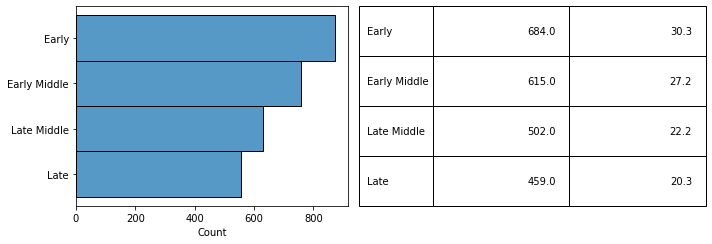

In [3]:
#hide_input
plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(10,3.5))

ax1 = fig.add_subplot(122)
ax1.axis('off')
bbox = [0,0,1,1]
mpl_table = ax1.table(cellText =yearly_grouping_df.values, bbox=bbox, rowLabels=yearly_grouping_df.index)

ax2 = fig.add_subplot(121)
hist = sb.histplot(y='Year Grouping', data=players_df, ax=ax2)
hist.set(ylabel=None)

plt.show()


There are 684 players born in the 'Early' grouping months, while there are only 459 players born in the 'Late' grouping. That means that 30.3% of players fall into 'Early' and 20.3% are categorized as 'Late'. That is close to the 32.9% to 16.2% found by Barnsley et al. in 1985. It means that for every 10 players born in the months of October, November, or December who make the NHL there are roughly 15 making it born in the months of January, February, or March. This is just a visualization and its not attempting to prove statistically significance, but those numbers certainly suggest a pronounced correlation. 

So given that the birth month trend certainly looks to be holding in todays NHL, lets explore a little deeper. Below is a boxplot without outliers (https://en.wikipedia.org/wiki/Box_plot). It visualizes the different percentiles players from the each grouping fall into. Take the time to filter between the different stats available and see the trends, and checkout how that changes when you set it to show the stats on a per game basis rather than career totals.

In [24]:
#hide

output_notebook()
x_value = 'assists'
y_value = 'Year Grouping'

categories = career_stats_df[y_value].unique().tolist()
options = ['Total', 'By Game']

# if lower bound is less than zero, zero it
def greaterThanZero(x):
    return x if (x > 0) else 0

selections = ColumnDataSource(data = dict(selected=['assists'], by=[0]))
sources = {}
data_sources = { 0: {}, 1: {}};
select = 0;
x_axis_values = career_stats_df.select_dtypes([number]).columns

def calculate_quantiles(x, y, source_dataframe): 
    df = source_dataframe[[
        y, 
        x, 
    ]]
    groups = df.groupby(y)
    q1 = groups.quantile(q=0.25).reindex(categories)
    q2 = groups.quantile(q=0.5).reindex(categories)
    q3 = groups.quantile(q=0.75).reindex(categories)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    lower[x] = lower[x].apply(greaterThanZero)
    
    source_dict = {
        'y': categories,
        'lower': lower[x],
        'q1': q1[x],
        'q2': q2[x],
        'q3': q3[x],
        'upper': upper[x]
    }
    return source_dict

for x_axis_value in x_axis_values: 
    total_dict = calculate_quantiles(x_axis_value, y_value, career_stats_df)
    data_sources[0][x_axis_value] = total_dict
    if (x_axis_value not in ['games', 'shooting percentage']):
        per_game_dict = calculate_quantiles(x_axis_value, y_value, career_stats_by_game_df)
        data_sources[1][x_axis_value] = per_game_dict  
    
tooltips = """
<div>
    <span style="font-size: 12px; font-weight: bold;">@y</span>&nbsp;
</div>
<div>
    <span style="font-size: 10px;">Lower bounds: @lower</span><br>
    <span style="font-size: 10px;">First quartile: @q1</span><br>
    <span style="font-size: 10px;">Median: @q2</span><br>
    <span style="font-size: 10px;">Third quartile: @q3</span><br>
    <span style="font-size: 10px;">Upper bounds: @upper</span>
</div>
"""
p = figure(y_range=categories, tooltips=tooltips, aspect_ratio=3, width=840, toolbar_location=None)

source = ColumnDataSource(data=data_sources[0][x_value])

hbar = HBar(
        y='y', 
        height=0.6,
        left='q1',
        right='q3',
        fill_color = Colorblind[8][0]
)

lower_segment = Segment(x0='lower', y0='y', x1='q1' ,y1='y')
upper_segment = Segment(x0='q3', y0='y', x1='upper' ,y1='y')
lower_rect = Rect(x='lower', y='y', width=0.001, height=0.8)
middle_rect = Rect(x='q2', y='y', width=0.001, height=0.8)
upper_rect = Rect(x='upper', y='y', width=0.001, height=0.8)

p.add_glyph(source, hbar)
p.add_glyph(source, lower_segment)
p.add_glyph(source, upper_segment)
p.add_glyph(source, lower_rect)
p.add_glyph(source, middle_rect)
p.add_glyph(source, upper_rect)

x_select = Select(options=x_axis_values.tolist(), value=x_value, width=420, height=30)
x_select.js_on_change("value", CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), 
code="""
    selections.data = {'selected': [this.value], 'by': [selections.data.by]};
    selections.change.emit();
    const new_data = data_sources[selections.data.by][this.value]
    source.data = new_data;
    source.change.emit();
"""))
breakout_radio = RadioButtonGroup(labels=options, active=0, width=420, height=30)
breakout_radio.js_on_click(CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), code="""
    selections.data = {'selected': [selections.data.selected], 'by': [this.active]};
    selections.change.emit();
    const new_data = data_sources[this.active][selections.data.selected[0]]
    source.data = new_data;
    source.change.emit();
    console.log(new_data)
"""))

columns = [
    TableColumn(field='y', title='Grouping'),
    TableColumn(field="lower", title='0th Percentile'),
    TableColumn(field="q1", title='25th Percentile'),
    TableColumn(field="q2", title='50th Percentile'),
    TableColumn(field="q3", title='75th Percentile'),
    TableColumn(field="upper", title='100th Percentile'),
]
table = DataTable(source=source, columns=columns, index_position=None, width=840,aspect_ratio=3)

layout = column(row(x_select,breakout_radio), p, table)

output_file('birthmonth_boxplot.html')
# show the results
show(layout)

Loading BokehJS ...

In [29]:
#hide_input
display(HTML('./birthmonth_boxplot.html'))

Its interesting data, and looking at it the shape of it here's what I notice
1. Players from the later months seem to perform better in skill metrics both in total and per game. They look to be scoring more goals, recording more assists, and taking more shots than those born in earlier months. 
2. The Early Middle category is weird. They are scoring almost 10 points less per game at the median than Early players when looking at total stats. Per game however they are scoring more at the median than the Early category. Is it possible the spring months tend to turn out low scoring grinders or injury prone stars? There's more to look into here.
3. The Early category plays to their size advantage. They're throwing more hits, and recording more penalty minutes than the other categories.

This is just a visualization of the data, its not trying to prove anything. It's job is to suggest trends in the data that could lead to more certainty. But with that said, its time to draw some very loosely founded conclusions about whats being seen here. 

Its tempting to look at this and think that players born in the later months really are more skilled than those born in the earlier months. That they are overcoming a road that places them at a disadvantage, and being rewarded with a more fruitful career. But I think that is only part of what we're seeing here. Hockey is not just a skill game, good teams require players who can kill penalties, land big hits, and shutdown opposing scorers. In those roles there is a big advantage to being big. I think likely what is happening is that those roles are generally given to players born in the earlier months as they are coming up through their minor hockey careers as they are the ones who will tend to be bigger. They learn what it takes to play those roles, and when it becomes time to slot into them at a NHL level they are the ones who have had the opportunity to get their 10000 hours of heavy hockey in. 

So whats next in exploring this data? I think there is work to be done breaking the data up by position and nationality. Different countries have different start dates, and it would be interesting to see if the effect is prominent based on when that is. By position you might be able to see the effect of the heavier roles finding their way into the vizualizations. Perhaps defencemen's birthdates skew harder to the start of the year? I think it would be also interesting to break the data down further into player roles. Likely, Using some heuristics to classify players by the role they are most likely to play for a team and seeing how birth date correlates would lead somewhere interesting. 

For now, it certainly looks like the relative age effect is alive and well in the modern NHL.